In [104]:
using Convex
using SCS
using PyPlot
using Distributions
srand(123);

In [105]:
function around!(x, res, start, n, d)
    dim = size(x, 2)
    for i=1:n
        res[start+i, 1] = x[1] + rand(d)
        res[start+i, 2] = x[2] + rand(d)
    end
end

around! (generic function with 1 method)

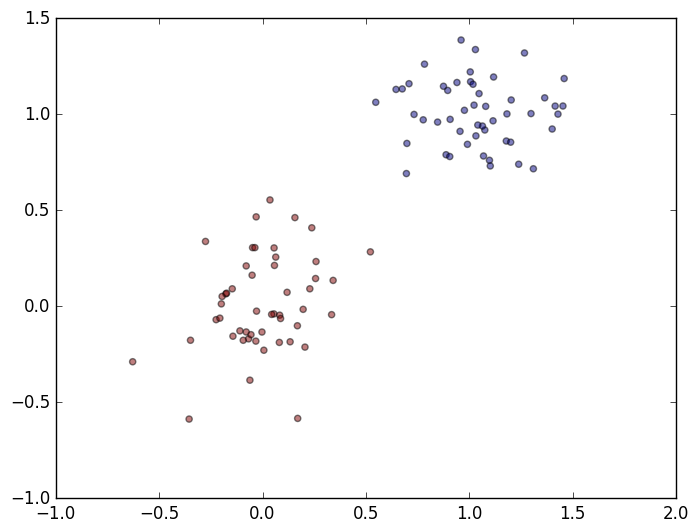

PyObject <matplotlib.collections.PathCollection object at 0x7f241a3670d0>

In [106]:
d = Normal(0, 0.2)

x = zeros(100, 2)
around!([0 0], x, 0, 50, d)
around!([1 1], x, 50, 50, d)

y = repeat([1; -1], inner=50)

scatter(x[:, 1], x[:, 2], c=y, alpha=0.5)

In [107]:
function make_Q(K, x, y)
    N = size(x, 1)
    Q = zeros(N, N)
    
    for i=1:N
        for j=1:N
            Q[i, j] = K(x[i, :], x[j, :]) * y[i] * y[j]
        end
    end
    
    min_ev = eigmin(Q)
    
    if min_ev < 0
        Q - min_ev .* I
    else
        Q
    end
end

make_Q (generic function with 3 methods)

In [123]:
N = size(x, 1)
α = Variable(N, 1)

K(x1, x2) = vecdot(x1, x2)
Q = make_Q(vecdot, x, y)

problem = minimize(0.5*quadform(α, Q) - vecdot(α, ones(N)))
problem.constraints += α >= 0
problem.constraints += vecdot(α, y) == 0

solve!(problem, SCSSolver(verbose=false))
α = max(α.value[:, 1], zeros(N));

In [124]:
w = zeros(2)
for i = 1:N
    if α[i] > 0
        w += α[i] * y[i] * x[i, :]
    end
end
w

2-element Array{Float64,1}:
 -2.20487
 -3.9615 

In [125]:
b = 0
for i = 1:N
    if α[i] > 0
        b = y[i] - vecdot(x[i, :], w)
        break
    end
end
b

3.2762171153886834

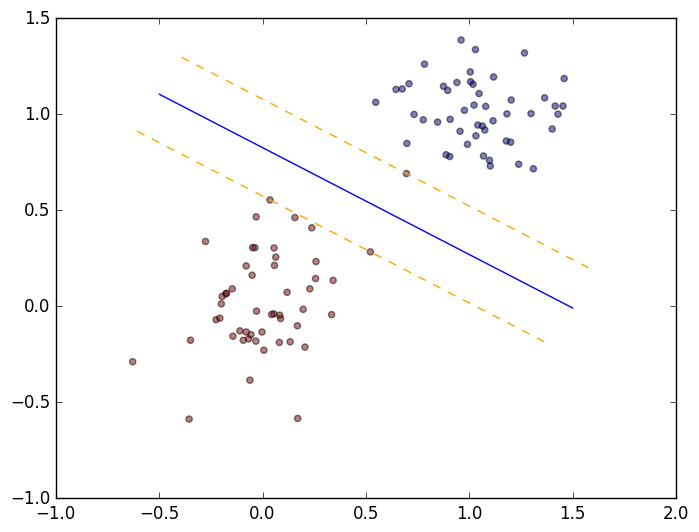

PyObject <matplotlib.collections.PathCollection object at 0x7f241a0728d0>

In [126]:
hor = linspace(-0.5, 1.5)
ver = -(b + hor * w[1]) / w[2]

hor_hi = hor + (w[1] / vecdot(w, w))
ver_hi = ver + (w[2] / vecdot(w, w))

hor_lo = hor - (w[1] / vecdot(w, w))
ver_lo = ver - (w[2] / vecdot(w, w))

plot(hor, ver)
plot(hor_hi, ver_hi, c="orange", ls="dashed")
plot(hor_lo, ver_lo, c="orange", ls="dashed")
scatter(x[:, 1], x[:, 2], c=y, alpha=0.5)